<a href="https://colab.research.google.com/github/waleedGeorgy/deep-learning/blob/main/Deep_Learning_Research_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll try to replicate the research paper "**An Image Is Worth 16X16 Words: Transformers For Image Recognition At Scale**" - [Paper here](https://arxiv.org/abs/2010.11929)

# Setting up

In [2]:
# Getting the necessary imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Checking for TorchInfo availability, and downloading it if it's not
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 42.17 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
data_path = download_data(source = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                          destination = 'pizza_steak_sushi')

data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = data_path / 'train'
test_dir = data_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Creating datasets and DataLoaders

- As described in the research paper, we'll try to replicate the ViT (vision transformer) architecture and apply it to our own problem.
- To start off, we'll need to resize the images to 224x224, and use a batch size of 4096.
- The former is easy to achieve but the latter may prove too much for the basic hardware provided by Google Colab. So, we'll stick to a batch size of 32.

In [ ]:
# Creating the manual transform
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
# Creating the dataloaders
import os

BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = BATCH_SIZE,
                                                                               num_workers = os.cpu_count())

In [ ]:
class_names, len(train_dataloader), len(test_dataloader)

(['pizza', 'steak', 'sushi'], 8, 3)

# Visualizing an image

In [ ]:
# Getting a single batch from the train dataloader
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(1))

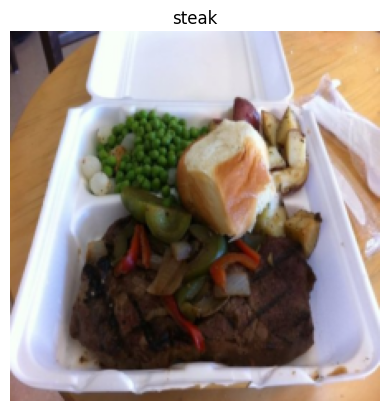

In [ ]:
# Visualizing the img and labeling it
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label]);

# Overview of the ViT

The ViT described in the paper can be broken down into these basic component:
- **INPUTS** - What goes into a layer / block / model? (e.g. batches of image tensors).
- **OUTPUTS** - What goes out of a layer / block / model? (e.g. classification labels & predictions).
- **LAYERS** - Take an input, and manipulate it with a mathmatical equation or function. (self-attention / multi-head attention, LayerNorm, etc...)
- **BLOCKS** - A group of layers.
- **MODEL** - A group of blocks.

## ViT in more detail
The components we'll need in order to build the model described in the research paper can be extracted from three main sources:

### Figure 1
Main model architecture (p. 3)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

[**Embeddings**](https://www.ibm.com/topics/embedding) are numerical representations of real-world objects that ML and AI systems use to understand complex knowledge domains like humans do. As an example, computing algorithms understand that the difference between 2 and 3 is 1, indicating a close relationship between 2 and 3 as compared to 2 and 100. However, real-world data includes more complex relationships. For example, a bird-nest and a lion-den are analogous pairs, while day-night are opposite terms. Embeddings convert real-world objects into complex mathematical representations that capture inherent properties and relationships between real-world data. The entire process is automated, with AI systems self-creating embeddings during training and using them as needed to complete new tasks.

---

### The Four Equations
The mathmatical representations of the layers in ViT (p. 4)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

- **Equations 1:**

The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathrm{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

[**What is a Transformer model?**](https://blogs.nvidia.com/blog/what-is-a-transformer-model/)

```
# Equation 1
x_input = [class_token, img_patch_1, img_patch_2, ..., img_patch_N] + [class_token_pos, img_patch_1_pos, img_patch_2_pos, ..., img_patch_N_pos]
```

- **Equation 2 & 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019). The MLP contains two layers with a GELU non-linearity.

**Layer normalization (LN)** - is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy. It computes the mean and standard deviation across each individual observation (over all channels in case of images) rather than across the batch. This makes it batch-size independent and can therefore be used in models like RNNs or in transformer models.

[**What is self-attention?**](https://h2o.ai/wiki/self-attention/)

[**What is multihead-attention?**](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)

[**Difference between Attention, Self-Attention and Multi-Head Attention?**](https://www.adityaagrawal.net/blog/deep_learning/attention)

```
# Equation 2:
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3:
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

The output of each block is a combination of the actual output of the block + the raw input of the same block using a residual connection.

**Residual connections** -  are links that connect some layers in a neural network to other layers that are not directly adjacent. For example, in a typical convolutional neural network (CNN), each layer receives input from the previous layer and passes output to the next layer. However, with residual connections, some layers can also receive input from or send output to layers that are several steps away. This creates a parallel path for information flow that bypasses some intermediate layers.


They work by adding the output of a previous layer to the input of a later layer. This means that the later layer does not have to learn the entire function that maps the input to the output, but only the residual or difference between them. For example, if the input is x and the output is y, then the layer with a residual connection only has to learn the function f(x) such that y = x + f(x). This makes the learning process easier and more stable, as the layer can simply learn an identity function f(x) = 0 if there is no difference between x and y.

Residual connections are beneficial for several reasons.
**First**, they help alleviate the problem of vanishing or exploding gradients, which occurs when the gradients of the loss function become too small or too large as they propagate back through the network. This can cause the network to stop learning or diverge. Residual connections allow the gradients to flow more directly and smoothly through the network, avoiding these extremes.
**Second**, they help prevent overfitting, which occurs when the network memorizes the training data and fails to generalize to new data. Residual connections introduce some regularization and diversity to the network, making it less prone to overfitting. Third, they help avoid degradation, which occurs when the network performance deteriorates as more layers are added. Residual connections enable the network to preserve or improve its performance by learning incremental features rather than redundant or irrelevant ones.

- **Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathrm{z}_0^0=\mathrm{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathrm{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathrm{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

**BERT** - short for Bidirectional Encoder Representations from Transformers, is a ML model for natural language processing based on the transformer architecture. It helps models understand ambiguous language in text by using surroudning text to establish context.

**MLP** = Multi-layer perceptron, a general term for FNNs with x number of layers.

In our case

**MLP** = one hidden layer at pre-training time.

**MLP** = one linear layer at fine-tuning time.

```
# Equation 4
y = linear_layer(LN_layer(x_output_MLP_block))
```

---

### Table 1
ViT model variants (p. 5)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

For starters, we'll replicate the ViT-Base variant ViT-B/16 (ViT-Base with 16x16 patch size).
* **Layers** = the number of transformer encoder layers (L).
* **Hidden size $D$** = the size of the embedding.
* **MLP size** = the number of hidden units in the MLP layers.
* **Heads** = The number of heads in the MSA layers.


# Equation 1: Turning input images into patches and creating patch, position and class embeddings.

## Turning an image into patches

First let's figure out the input and output shapes of the flattened embeddings layer.

Input shape = $H\times{W}\times{C}$

Output shape = ${N \times\left(P^2 \cdot C\right)}$

Where:
- H = Height
- W = Width
- C = Color channels
- P = Size of patches
- N = Number of patches = $HW/P^2$

The flattened embedding input is a 1D vector of size $D$

In [ ]:
# Hardcoding an example
# In our case, we'll have 224x224 colored images, and patch size of 16 (ViT-B/16)
height = 224
width = 224
color_ch = 3
patch_size = 16

num_of_patches = int(height*width / patch_size**2)
num_of_patches

196

In [ ]:
# Calculating the input and output shapes
input_shape = (height, width, color_ch)
output_shape = (num_of_patches, patch_size**2*color_ch)

print(f'Input image shape: {input_shape} -> (height, width, color channels)')
print(f'Output image shape (single 1D sequence of patches): {output_shape} -> (number of patches, size of embedding)')

Input image shape: (224, 224, 3) -> (height, width, color channels)
Output image shape (single 1D sequence of patches): (196, 768) -> (number of patches, size of embedding)


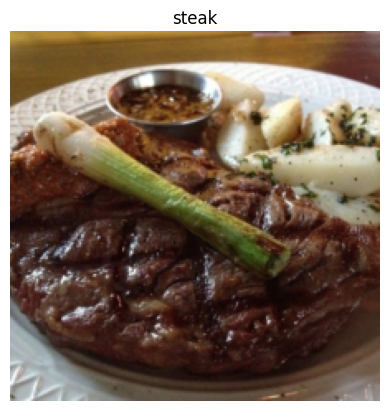

In [ ]:
# Let's visualize an image to compare its size to our model requirements
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
img.shape

torch.Size([3, 224, 224])

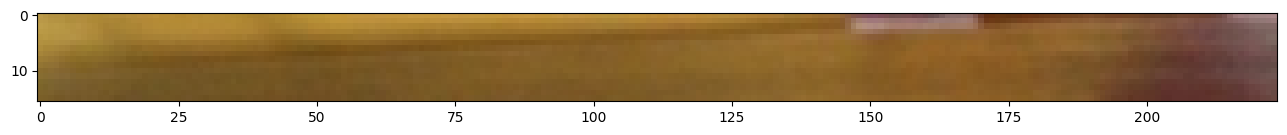

In [ ]:
# To replicate turning an input image into patches, let's first try to plot a single row from an image
img_permuted = img.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permuted[:patch_size,:,:])

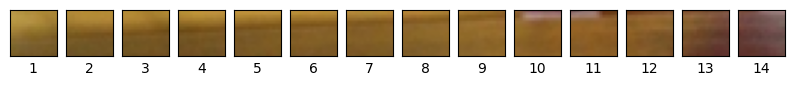

In [ ]:
# Now let's turn this row into patches
img_size = 224
patch_size = 16
num_of_patches = int(img_size / patch_size)

if img_size % patch_size == 0:
  fig, axis = plt.subplots(nrows = 1,
                          ncols = num_of_patches,
                          sharex=True,
                          sharey = True,
                          figsize = (10, 10))

  for i, patch in enumerate(range(0, img_size, patch_size)):
    axis[i].imshow(img_permuted[:patch_size, patch : patch + patch_size, :])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])
else:
  print(f'Image size of {img_size} is not divisible by patch size of {patch_size}')

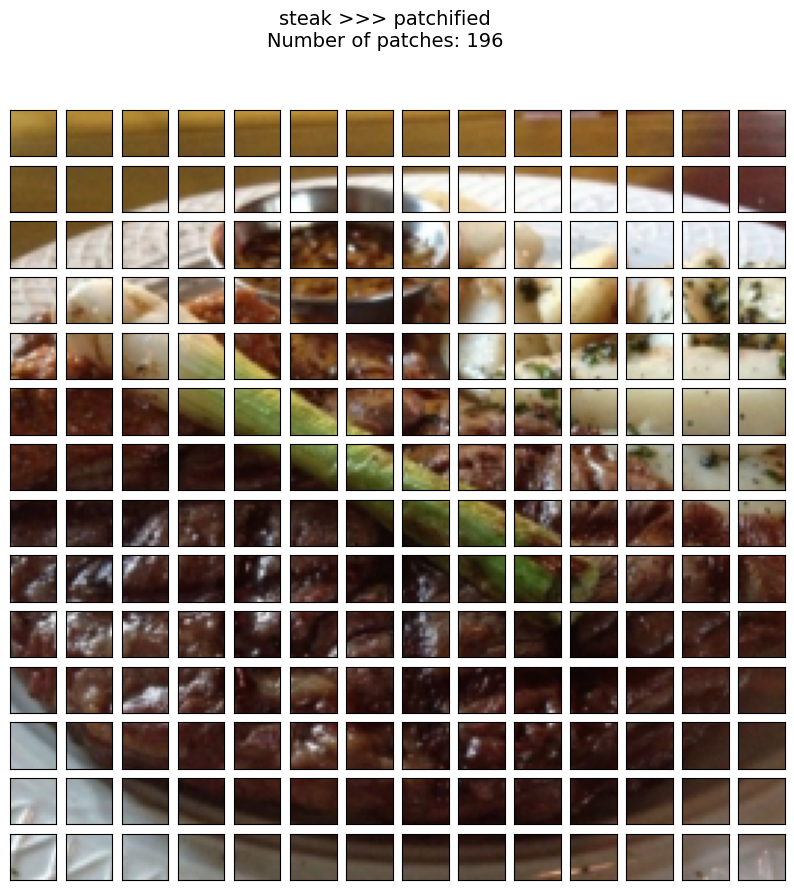

In [ ]:
# Now for the entire image
height = 224
width = 224
patch_size = 16
num_of_patches_h = int(height / patch_size)
num_of_patches_w = int(width / patch_size)

if height % patch_size == 0 and width % patch_size == 0:
  fig, axis = plt.subplots(nrows = num_of_patches_h,
                          ncols = num_of_patches_w,
                          sharex=True,
                          sharey = True,
                          figsize = (10,10))

  for i, patch_h in enumerate(range(0, height, patch_size)):
    for j, patch_w in enumerate(range(0, width, patch_size)):
      axis[i,j].imshow(img_permuted[patch_h : patch_h + patch_size, patch_w : patch_w + patch_size, :])
      axis[i,j].set_xticks([])
      axis[i,j].set_yticks([])
      suptitle = f'{class_names[label]} >>> patchified\nNumber of patches: {num_of_patches_h*num_of_patches_w}'
      fig.suptitle(suptitle, fontsize = 14)
else:
  print(f'Image size of {img_size} is not divisible by patch size of {patch_size}')

## Turning patches into patch embeddings

As described in the research paper, we can turn our patches into patch embeddings using a convolutional layer, and then flattening these embeddings. The Conv2D layer will create patches of learnable feature maps, and the Flatten layer will flatten these patches and turn them into a 1-D input vector.

In [ ]:
# Creating the conv2d layer
from torch import nn

PATCH_SIZE = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels = 768,
                   stride = PATCH_SIZE,
                   kernel_size = PATCH_SIZE,
                   padding = 0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
# Passing an image through the conv2d layer
img_out_conv = conv2d(img.unsqueeze(0))
print(f'{img_out_conv.shape} -> (batch, embedding size, Feature map (embedding) Height, Feature map (embedding) Width)')

torch.Size([1, 768, 14, 14]) -> (batch, embedding size, Feature map (embedding) Height, Feature map (embedding) Width)


Showing random feature maps: [681, 610, 646, 371, 113]


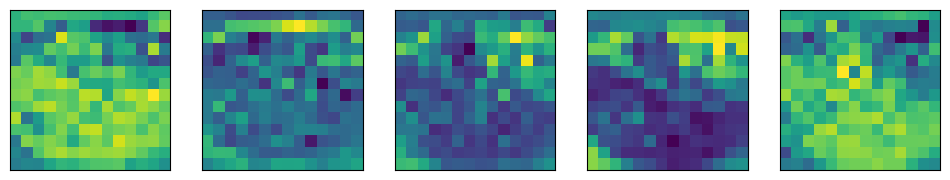

In [ ]:
# Plotting random feature maps (embeddings) from our patched image
import random
random_idx = random.sample(range(0, 768), k = 5)
print(f'Showing random feature maps: {random_idx}')

fig, axis = plt.subplots(nrows = 1,
                         ncols = 5,
                         figsize = (12,12))

for i, idx in enumerate(random_idx):
  conv_feature_maps = img_out_conv[:, idx, :, :]
  axis[i].imshow(conv_feature_maps.squeeze(0).detach().numpy())
  axis[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

**These random patches are learnable representations of the image we passed through the conv2d layer**

In [ ]:
img_out_conv.shape

torch.Size([1, 768, 14, 14])

This is the shape of the image after passing through the conv2d layer. We need the input to be of shape (1, 196, 768) (patch_size (equals 1 in our example), number_of_patch_embeddings, size_of_embedding). i.e. we need to flatten the patches into a sequence to satisfy the requirements of the ViT input.

In [ ]:
# Now we'll flatten each embedding from the patched image using nn.Flatten()
flatten_layer = nn.Flatten(start_dim = 2, end_dim = -1)
# Passing the image through the Flatten layer
flattened_img = flatten_layer(img_out_conv)
flattened_img.shape

torch.Size([1, 768, 196])

In [ ]:
# Manipulating dimensions to get the desired shape
flattened_img = flattened_img.permute(0,2,1)
flattened_img.shape

torch.Size([1, 196, 768])

Finally we can see how we went from a raw input 2D image (224, 224) into a 1D sequence of patch embeddings of shape (1, 196, 768)

Plotting three random falttened patches of indexes: [449, 590, 80]


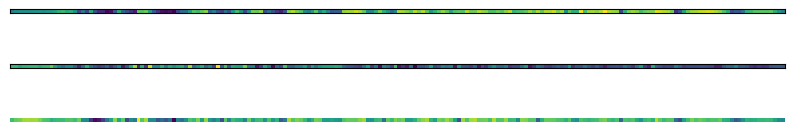

In [ ]:
# Let's visualize a random pick of 3 flattened patches
random_idx = random.sample(range(0,768), k = 3)
print(f'Plotting three random falttened patches of indexes: {random_idx}')

fig, axis = plt.subplots(nrows = 3, ncols = 1, figsize = (10,2))
plt.axis(False)
for i, idx in enumerate(random_idx):
  flattened_patch = flattened_img[:,:,idx]
  axis[i].imshow(flattened_patch.detach().numpy())
  axis[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

## Combining the previous two actions into a single class

In [ ]:
# Creating a single class that will handle creating patch embeddings from input images for the ViT-Base
class PatchEmbedding(nn.Module):
  """
  Transforms a 2D input image into a 1D vector of patch embeddings.

  Serves as data preparation for the ViT-Base/16 transformer.

  Args:
    - in_channels: (int) the number of channels in the input image (default = 3).
    - embedding_size: (int) the size of the flattened input embedding to the ViT (default = 768).
    - patch_size: (int) the size of patches created from the image (default = 16).
  """
  # Defining the contructor
  def __init__(self,
               in_channels: int = 3,
               embedding_size: int = 768,
               patch_size: int = 16):
    super().__init__()
    # The patch embedding creator sequential block
    self.patch_creator = nn.Sequential(
        # The convolutional layer the will create the patch embeddings
        nn.Conv2d(in_channels = in_channels,
                  out_channels = embedding_size,
                  kernel_size = patch_size,
                  stride = patch_size,
                  padding = 0),
        # The flattening layer that will flatten the patch embedding into a 1D vector
        nn.Flatten(start_dim = 2,
                   end_dim = 3)
    )

  # Defining the forward method
  def forward(self, x):
    # Checking for image and patch size mismatching
    img_width = x.shape[-1]
    img_height = x.shape[-2]
    if img_height % patch_size == 0 and img_width % patch_size == 0:
      output_img = self.patch_creator(x)
      # Returning the permuted image to match the requirements of the ViT input
      return output_img.permute(0,2,1) # permute to (batch_size, patch_size, embedding_size)
    else:
      print(f'Could not create patches because the image size of ({img_height}x{img_width}) is not divisible by the patch size of {patch_size}')

In [ ]:
# Testing out the patch embeddings creator class
torch.manual_seed(42)
torch.cuda.manual_seed(42)

patchify_img = PatchEmbedding(in_channels = 3,
                              embedding_size = 768,
                              patch_size = 16)

batched_img = img.unsqueeze(0)

print(f'Input image shape: {batched_img.shape}')
patch_embedded_img = patchify_img(batched_img)
print(f'Patch embedded image shape: {patch_embedded_img.shape}')

Input image shape: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])


## Creating the extra learnable classification token

In [ ]:
# First let's create variables for batch size and embedding size for ease
batch_size = patch_embedded_img.shape[0]
embedding_size = patch_embedded_img.shape[-1]

batch_size, embedding_size

(1, 768)

We will create the extra learnable with the nn.Parameter with gradient tracking

In [ ]:
# For starters we will create the learnable class tokens with values of 1
# to easily distinct them for demonstration purposes
# In reality we will replace torch.ones with torch.randn
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_size),
                           requires_grad = True)

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Adding the class token to the patch embeddings
class_embedded_img = torch.cat((class_token, patch_embedded_img),
                            dim = 1)

class_embedded_img.shape

torch.Size([1, 197, 768])

We got the desired shape of (batch_size, class_embedding + patch_embeddings, embedding_size)

In [ ]:
# The top left value in the tensor is the classification embedding
class_embedded_img

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4712,  0.0765, -0.0737,  ...,  0.2956, -0.2897,  0.1292],
         [-0.4461,  0.0852, -0.0519,  ...,  0.2821, -0.2829,  0.1026],
         ...,
         [-0.4606,  0.1004, -0.1175,  ...,  0.2365, -0.1402,  0.1471],
         [-0.5201,  0.1533, -0.1915,  ...,  0.3471, -0.1987,  0.1190],
         [-0.5454,  0.1380, -0.2372,  ...,  0.4155, -0.2121,  0.1626]]],
       grad_fn=<CatBackward0>)

## Creating the position embedding

This will be done in a similar fashion to class embedding

In [ ]:
# Let's first get the number of patches
num_patches = int((height * width) / patch_size**2)
embedding_size = class_embedded_img.shape[-1]
num_patches, embedding_size

(196, 768)

In [ ]:
# Creating the position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             num_patches + 1,
                                             embedding_size),
                                  requires_grad = True)

position_embedding.shape, position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True))

In [ ]:
# Adding the position embedding to the patch + class embeddings
patch_class_position_embedding = class_embedded_img + position_embedding
patch_class_position_embedding, patch_class_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.5288, 1.0765, 0.9263,  ..., 1.2956, 0.7103, 1.1292],
          [0.5539, 1.0852, 0.9481,  ..., 1.2821, 0.7171, 1.1026],
          ...,
          [0.5394, 1.1004, 0.8825,  ..., 1.2365, 0.8598, 1.1471],
          [0.4799, 1.1533, 0.8085,  ..., 1.3471, 0.8013, 1.1190],
          [0.4546, 1.1380, 0.7628,  ..., 1.4155, 0.7879, 1.1626]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## Putting everything together

Now we'll put everything into 1 cell and see how a 2D input image transforms into a 1D vector of patch + class + postition embeddings

In [ ]:
# Setting the seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setting some parameters
patch_size = 16
img_height = img.shape[1]
img_width = img.shape[2]

# Adding the batch dimension
x = img.unsqueeze(0)
print(f'Shape of input image: {x.shape}')

# Create patch embeddings
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       embedding_size = 768,
                                       patch_size = patch_size)

# Patchifying the image
x_patchified = patch_embedding_layer(x)
print(f'Patch embedding shape: {x_patchified.shape}')

# Getting patch dimentions
batch_size = x_patchified.shape[0]
embedding_size = x_patchified.shape[-1]

# Creating and adding the classification extra learnable
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_size),
                                    requires_grad = True)

print(f'Shape of class embedding: {class_token.shape}')

x_patchified_class_token = torch.cat((class_token, x_patchified), dim = 1)
print(f'Shape of patch embedding + class token: {x_patchified_class_token.shape}')

# Creating and adding position embedding
num_of_patches = int((img_height*img_width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(batch_size, num_of_patches + 1, embedding_size),
                                  requires_grad = True)
print(f'Shape of posistion embedding: {position_embedding.shape}')

x_patchified_class_position_embedding = x_patchified_class_token + position_embedding
print(f'Shape of input embedding: {x_patchified_class_position_embedding.shape}')

Shape of input image: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Shape of class embedding: torch.Size([1, 1, 768])
Shape of patch embedding + class token: torch.Size([1, 197, 768])
Shape of posistion embedding: torch.Size([1, 197, 768])
Shape of input embedding: torch.Size([1, 197, 768])


In [ ]:
x_patchified_class_position_embedding

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-1.1662,  0.7953, -1.2147,  ..., -0.0197, -2.5119, -0.5630],
         [-2.0316, -0.2324, -1.4531,  ...,  2.0804,  0.2249,  0.1341],
         ...,
         [ 0.8249,  0.9307,  0.0321,  ..., -0.2386,  1.1262,  0.8229],
         [-0.5607, -0.3638, -0.5403,  ..., -0.1451,  0.1516,  1.4661],
         [-0.7908,  0.1333,  1.2612,  ...,  0.0079,  1.3664, -0.1655]]],
       grad_fn=<AddBackward0>)

# Equation 2: Multi-head self-attention (MSA)

As discribed in the research paper, the MSA block consists of a LayerNorm layer and a MSA layer + the original input (residuals).
- The LayerNorm normalizes the distribution of the input embeddings per-sample, making the input batch-independent, and consequently suitable for the ViT.
- The MSA layer learns context in an input vector, i.e. what parts of the input relate strongly to each other.

In the case of image patches, we need to find what patches are strongly related to each other. This relationship will hopefully be learned by the ViT.


In [ ]:
# Here we'll create a class that replicates the MSA block
class MultiheadSelfAttention(nn.Module):
  def __init__(self,
               embedding_dimension:int = 768,
               num_heads:int = 12,
               dropout: float = 0):
    """
    Creates a multi-head self-attention block (MSA block) that consists of a
    LayerNorm layer and a MSA layer.
    """
    super().__init__()
    # Creating the LayerNorm layer
    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dimension)
    # Creating the MSA layer
    self.msa = nn.MultiheadAttention(embed_dim = embedding_dimension,
                                     num_heads = num_heads,
                                     batch_first = True) # To make batch size come first

  # Overwriting the forward function
  def forward(self, x):
    norm_x = self.layernorm(x)
    # MSA layer returns the outputs and their weights
    # Here, we don't need the weights, hence we use an underscore
    # and set the need_weights parameter to False
    msa_output, _ = self.msa(query = norm_x,
                             key = norm_x,
                             value = norm_x,
                             need_weights = False)
    return msa_output + x # Returning the msa output plus the block input as residuals

In [ ]:
msa_block = MultiheadSelfAttention()

In [ ]:
msa_block_output = msa_block(x_patchified_class_position_embedding)
msa_block_output.shape

torch.Size([1, 197, 768])

In [ ]:
msa_block_output

tensor([[[-0.4298, -2.8690, -1.0330,  ..., -0.2549,  1.8818,  0.5675],
         [-1.1151,  0.8581, -1.1696,  ...,  0.0355, -2.4753, -0.6991],
         [-1.9800, -0.1600, -1.4204,  ...,  2.1027,  0.2781, -0.0407],
         ...,
         [ 0.8974,  0.9852,  0.0186,  ..., -0.1994,  1.1883,  0.6389],
         [-0.4904, -0.3227, -0.5240,  ..., -0.1196,  0.1853,  1.2929],
         [-0.7283,  0.1871,  1.2672,  ...,  0.0308,  1.4170, -0.3365]]],
       grad_fn=<AddBackward0>)

In [ ]:
# Here we see that the tensor values have changed, which means that the MSA block
# is operational
x_patchified_class_position_embedding

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-1.1662,  0.7953, -1.2147,  ..., -0.0197, -2.5119, -0.5630],
         [-2.0316, -0.2324, -1.4531,  ...,  2.0804,  0.2249,  0.1341],
         ...,
         [ 0.8249,  0.9307,  0.0321,  ..., -0.2386,  1.1262,  0.8229],
         [-0.5607, -0.3638, -0.5403,  ..., -0.1451,  0.1516,  1.4661],
         [-0.7908,  0.1333,  1.2612,  ...,  0.0079,  1.3664, -0.1655]]],
       grad_fn=<AddBackward0>)

# Equation 3: Multi-layer perceptron (MLP)

A MLP layer is a general term for a block of layers that contain any number of said layers. These layers are called linear, or dense or fully-connected etc.

In PyTorch these layers are the **nn.Linear** layers.

As described in the paper, the MLP block contains **two layers** with a **GELU** non-linearity. Additionally, a Dropout layer is applied after every dense layer.

So, the MLP block = nn.Linear > nn.Dropout > nn.GELU > nn.Linear > nn.Dropout

The number of hidden features inside the MLP block equals the size of MLP described in the paper which is equal to 3072.

The value for dropout is defined in table 3 and is equal to 0.1.


In [ ]:
# Creating the MLP block class
class MultiLayerPerceptron(nn.Module):
  """
    Creates a multi-layer perceptron block (MLP block) that consists of a
    LayerNorm layer and a MLP layer that has the architecture of: nn.Linear() ->
    nn.Dropout() -> nn.GELU() -> nn.Linear() -> nn.Dropout().
    """
  def __init__(self, embed_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):

    super().__init__()

    # Defining the LayerNorm layer
    self.layernorm = nn.LayerNorm(normalized_shape = embed_dim)

    # Building the MLP block
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embed_dim, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features=mlp_size, out_features = embed_dim),
        nn.Dropout(p = dropout)
    )

  # Overwriting the forward method
  def forward(self, x):
    return self.mlp(self.layernorm(x)) + x

In [ ]:
mlp_block = MultiLayerPerceptron()

In [ ]:
mlp_out_img = mlp_block(msa_block_output)

mlp_out_img.shape

torch.Size([1, 197, 768])

In [ ]:
mlp_out_img

tensor([[[-0.5502, -2.4039, -1.4618,  ..., -0.4642,  1.8818,  0.4150],
         [-1.1151,  0.9787, -1.3622,  ...,  0.0410, -2.6317, -0.2205],
         [-1.9554, -0.1699, -1.5434,  ...,  2.1252,  0.1087,  0.3449],
         ...,
         [ 0.6723,  1.0172,  0.3122,  ..., -0.2092,  1.3032,  0.4379],
         [-0.4130,  0.0724, -0.3815,  ..., -0.2191,  0.1897,  1.4335],
         [-0.9704,  0.2806,  0.9519,  ...,  0.2215,  1.3746, -0.3063]]],
       grad_fn=<AddBackward0>)

# Creating the Transformer Encoder

Now we'll put the block we created for the equations 2 & 3 into one single class.

The Encoder-Decoder architecture is widely used in Deep Learning. Basically it transforms an input into a certain state and the transforms that state into the desired output (For example translating using Google Translate).

In simple words, an encoder transforms an input, in our case a sequence of image patches, into a learnable representation.

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embed_dim: int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,
               msa_dropout: float = 0):
    """
    Creates the transformer encoder for the ViT-B/16 architecture.

    The encoder contains a MSA block (LayerNorm + MSA) and a MLP block (LayerNorm
    + MLP).
    """
    super().__init__()

    # Creating the MSA block
    self.msa_block = MultiheadSelfAttention(embedding_dimension = embed_dim,
                                            num_heads = num_heads,
                                            dropout = msa_dropout)

    # Creating the MLP block
    self.mlp_block = MultiLayerPerceptron(embed_dim = embed_dim,
                                          mlp_size = mlp_size,
                                          dropout = mlp_dropout)

  # Overwriting the forward method
  def forward(self, x):
    return self.mlp_block(self.msa_block(x))

In [ ]:
# Now let's get a summary of the encoder using TorchInfo
trans_enc = TransformerEncoder()

summary(model = trans_enc,
        input_size = (1,197,768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttention (msa_block)     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)             [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)          --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptron (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)             [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                  [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                   [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    │    └─GE

## Creating the Transformer Encoder with built-in classes

Transformer encoder layers and blocks can be created with PyTorch built-in classes very easily

In [ ]:
trans_enc_auto = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base = embedding dimension size
                                            nhead=12, # Number of MSA heads
                                            dim_feedforward=3072, # Number of hidden units in MLP
                                            dropout=0.1, # Amount of dropout fot the dense layers in MLP
                                            activation="gelu", # activation function
                                            batch_first=True, # Make batch size come first
                                            norm_first=True) # Apply LayerNorm before MLP and MSA layers

trans_enc_auto.to(device)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Getting a summary of the transformer encoder layer
summary(model = trans_enc_auto,
        input_size = (1,197,768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [ ]:
# Passing a patched image through the transformer encoder layer
img_output_auto = trans_enc_auto(x_patchified_class_position_embedding.to(device))

In [ ]:
img_output_auto.shape

torch.Size([1, 197, 768])

# Recreating the entire ViT architecture

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size:int = 224,
               img_channels: int = 3,
               embedding_size: int = 768,
               patch_size:int = 16,
               mlp_size:int = 3072,
               num_of_encoders:int = 12,
               num_of_msa_heads: int = 12,
               embedding_dropout: float = 0.1,
               msa_dropout: float = 0,
               mlp_dropout:float = 0.1,
               num_classes:int = 1000):
    """
    Creates the entire ViT-B/16 architecture.
    Patchified the input 2D image, adds classification embedding and position embedding,
    and passes the resulting 1D sequence of patches through multiple blocks of
    transformer encoders.
    All the default values are described in the research paper.
    Args:
      img_size: Height and width of the input image (default = 224).
      img_channels: Number of channels in the input image (default = 3).
      embedding_size: Size of the embedding dimension (default = 768).
      patch_size: Size of patches the input image will be transformed into (default = 16).
      mlp_size: Size of the hidden units in the MLP block (default = 3072).
      num_of_encoders: Number of transformer encoder blocks (default = 12)
      num_of_msa_heads: Number of MSA heads inside the transformer encoder (default = 12).
      embedding_dropout: Amount of dropout to be applied after adding the position embedding (default = 0.1)
      msa_dropout: Amount of dropout in the MSA block (default = 0)
      mlp_dropout: Amount of dropout in the MLP block (default = 0.1)
      num_classes: Number of classes in the classification problem. (default = 1000)
    """
    super().__init__()

    # Checking whether the image can be divided into patches
    assert img_size % patch_size == 0, f'Image size must be divisible by patch size'

    # Getting the number of patches
    self.num_of_patches = int((img_size * img_size) / patch_size**2)

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_size),
                                            requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_of_patches+1, embedding_size),
                                               requires_grad=True)

    # Position embedding dropout
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # Patch creator layer (creates image patches and adds class tokens and posistion embedding)
    self.patch_creator = PatchEmbedding(in_channels = img_channels,
                                                embedding_size = embedding_size,
                                                patch_size = patch_size)

    # Transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embed_dim=embedding_size,
                                                                  num_heads=num_of_msa_heads,
                                                                  mlp_size=mlp_size,
                                                                  mlp_dropout=mlp_dropout) for _ in range(num_of_encoders)])

    # The output MLP head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_size),
        nn.Linear(in_features=embedding_size,
                  out_features = num_classes)
    )

  # Overwriting the forward() method
  def forward(self, x):
    # Getting the image batch
    batch_size = x.shape[0]
    # Equation 1
    # Expanding the class token to the entire batch
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    # Patchifying the image
    patched_img = self.patch_creator(x)
    # Adding the class token
    patched_img_class_emb = torch.cat((class_token, patched_img), dim = 1)
    # Adding the position embedding
    patched_img_class_emb_pos_emb = patched_img_class_emb + self.position_embedding
    # Applying position embedding dropout
    trans_enc_input = self.embedding_dropout(patched_img_class_emb_pos_emb)
    # Equation 2 & 3
    # Passing the embeddings through the transformer encoder
    trans_enc_output = self.transformer_encoder(trans_enc_input)
    # Equation 4
    # Passing the 0th index (the classification token) through the classifier head
    img_class = self.classifier(trans_enc_output[:, 0])

    return img_class

In [ ]:
# Making a dummy pass through the model
vit_base_16 = ViT(num_classes=3)
img_class = vit_base_16(torch.randn(1,3,224,224))
img_class

tensor([[-1.1090,  0.1328, -0.6330]], grad_fn=<AddmmBackward0>)

In [ ]:
# Getting a summary of the model
summary(model = vit_base_16,
        input_size = (32,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_creator)                   [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Sequential (patch_creator)                  [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    │    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    │    └─Flatten (1)                            [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                 [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder (0)                  

# Training the created ViT-B/16 model on the FoodVision Mini dataset

As described in the research paper, in **table 3** and in **Training & Fine-tuning** section in p.5, these are the training parameters for the ViT-B/16:
- Optimizer = Adam
- Epochs = 7
- $B1$ = 0.9, $B2$ = 0.999
- Batch Size = 4096 (we will use 32)
- Base LR = 8.10^-4
- LR decay = Linear
- Weight decay = 0.1
- Dropout = 0

**Weight decay** - or L2 regularization is a regularization technique that adds a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

*loss = loss + weight decay parameter * L2 norm of the weights*

It penalizes the loss function and prevents the weights from getting too large (shrinks them towards zero) which consequently keeps the model from overfitting.

In [ ]:
# Setting the seeds to 42
set_seeds()

# Defining the optimizer
optimizer = torch.optim.Adam(params = vit_base_16.parameters(),
                             betas = (0.9, 0.999),
                             weight_decay = 0.1,
                             lr = 0.0008)

# Defining the loss function
loss_fn = nn.CrossEntropyLoss()

# Training the model on our custom data
vit_base_16_results = engine.train(model = vit_base_16,
                                   train_dataloader = train_dataloader,
                                   test_dataloader = test_dataloader,
                                   optimizer = optimizer,
                                   loss_fn = loss_fn,
                                   epochs = 7,
                                   device = device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6750 | train_acc: 0.3008 | test_loss: 1.6602 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6718 | train_acc: 0.2500 | test_loss: 1.7830 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.6658 | train_acc: 0.2461 | test_loss: 1.0755 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2570 | train_acc: 0.2539 | test_loss: 1.5777 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3523 | train_acc: 0.2930 | test_loss: 1.2299 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2089 | train_acc: 0.2969 | test_loss: 1.7781 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.3020 | train_acc: 0.4141 | test_loss: 2.4512 | test_acc: 0.1979


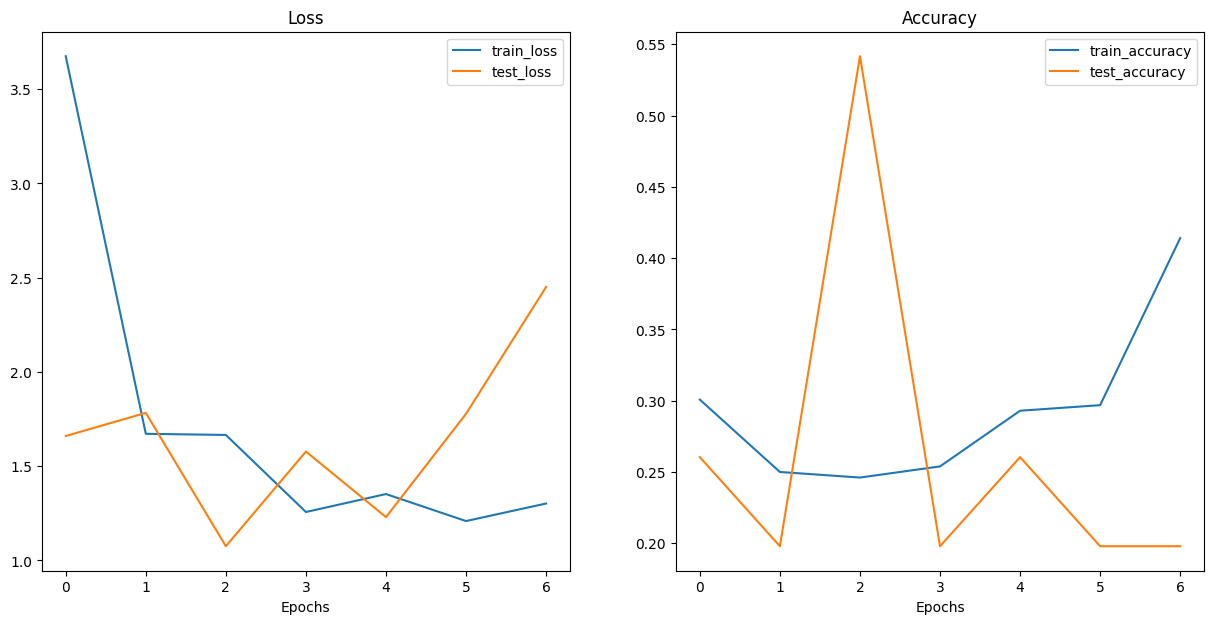

In [ ]:
# Let's plot the loss and accuracy curves
import helper_functions

plot_loss_curves(vit_base_16_results)

As we can see by the training results and the accuracy / loss curves, the ViT-B/16 model performed poorly on our custom dataset. The curves don't really paint any picture, and it is hard to tell whether the model is overfitting or underfitting.

The main reason for these poor results is the **scale**.

In the paper, very large datasets were used to attain great results (millions of images and thousands of classes), whereas in our application we have only 225 images and 3 classes.

One way of improving our results is to train for longer (more epochs) and/or use a larger dataset.

Another way of dealing with the poor reults is to use Transfer Learning. That's what we'll do next.

# Implementing a pretrained ViT model

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
# Getting the ViT-B/16 weights and creating the transform
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transform = vit_weights.transforms()

In [ ]:
# Creating the dataloaders
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = vit_transform,
                                                                               batch_size = 32,
                                                                               num_workers = os.cpu_count())

In [ ]:
# Getting the ViT-B/16 model with the DEFAULT weights
vit_model = torchvision.models.vit_b_16(weights = vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 81.2MB/s]


In [ ]:
summary(model = vit_model,
        input_size = (32,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [ ]:
# Creating feature extractor by freezing the backbone of Conv2D layer and the transformer encoders
for param in vit_model.conv_proj.parameters():
  param.requires_grad = False

for param in vit_model.encoder.parameters():
  param.requires_grad = False

In [ ]:
# Modifying the MLP classifier head to suit our application
vit_model.heads = nn.Sequential(
    nn.Linear(in_features = 768, out_features = 3, bias = True))

In [ ]:
summary(model = vit_model,
        input_size = (32,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Training the model
# Setting the seeds to 42
set_seeds()

# Defining the optimizer
optimizer = torch.optim.Adam(params = vit_model.parameters(),
                             betas = (0.9, 0.999),
                             weight_decay = 0.1,
                             lr = 0.0008)

# Defining the loss function
loss_fn = nn.CrossEntropyLoss()

# Training the model on our custom data
pretrained_vit_results = engine.train(model = vit_model,
                                     train_dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     optimizer = optimizer,
                                     loss_fn = loss_fn,
                                     epochs = 7,
                                     device = device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7849 | train_acc: 0.7578 | test_loss: 0.5725 | test_acc: 0.8570
Epoch: 2 | train_loss: 0.3788 | train_acc: 0.9414 | test_loss: 0.3563 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.2315 | train_acc: 0.9648 | test_loss: 0.2863 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1738 | train_acc: 0.9688 | test_loss: 0.2520 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1398 | train_acc: 0.9688 | test_loss: 0.2372 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.1355 | train_acc: 0.9688 | test_loss: 0.2220 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.1079 | train_acc: 0.9727 | test_loss: 0.2386 | test_acc: 0.9081


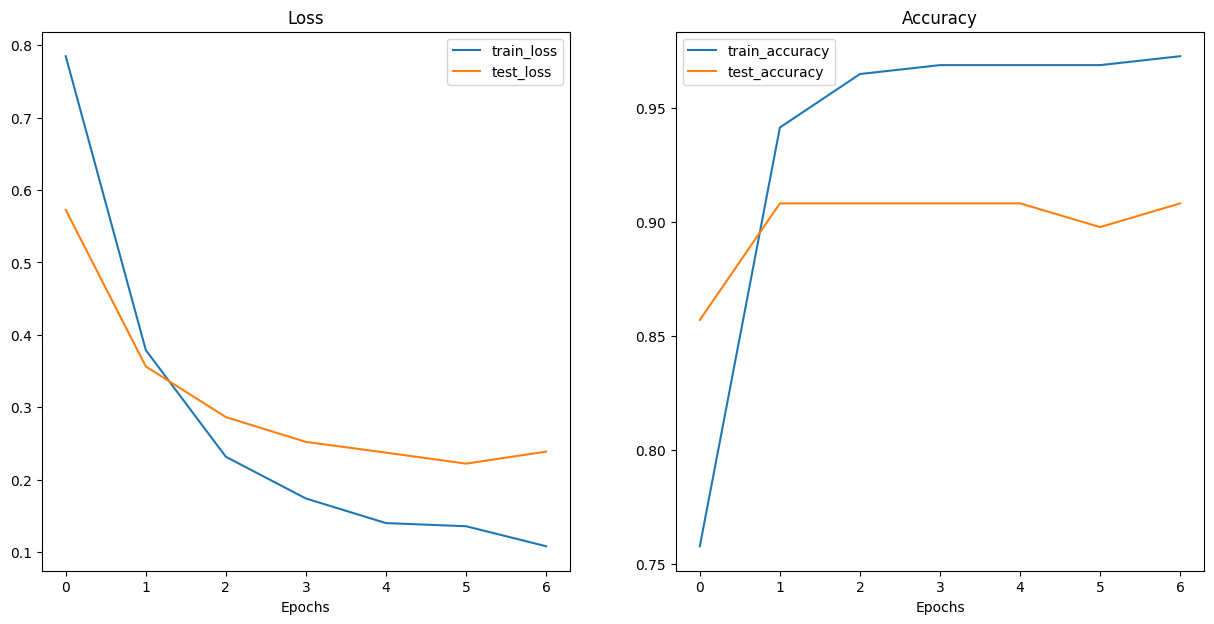

In [ ]:
# Plotting loss and accuracy curves
plot_loss_curves(pretrained_vit_results)

As expected using a pretrained model gave us superior results

In [ ]:
# Saving the best model
models_folder = '/content/models'
os.mkdir(models_folder)

model_name = 'vit_b_16.pth'
torch.save(vit_model.state_dict(), os.path.join(models_folder, model_name))

Despite training a very good model with small training time, there are some issues that we should point out. That main issue is the model's size, which in the case of ViT-B/16 is 327 MBs. This can be a problem if we're going to deploy our model on mobile devices or in a browser, and even though larger models are better, we have to think about the trade-off between model robustness and its ease of use and deployment.

To put into prespective, we trained an EfficientNetB2 on the same dataset and got almost equal reults, but the model size was +10 times smaller.

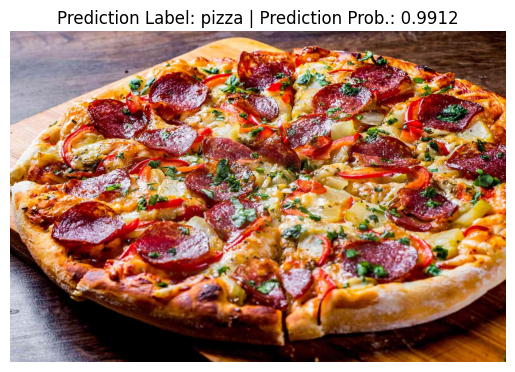

In [ ]:
# Making predictions on a custom image
custom_img_path = '/content/custom_pizza.jpg'
custom_img = torchvision.io.read_image(custom_img_path)
transformed_img = vit_transform(custom_img).unsqueeze(0).to(device)
vit_model.eval()
with torch.inference_mode():
  y_logits = vit_model(transformed_img)
  y_preds = torch.softmax(y_logits, dim = 1)
  y_label = y_preds.argmax(dim = 1)

  plt.imshow(custom_img.squeeze(0).permute(1,2,0))
  plt.axis(False)
  title = f'Prediction Label: {class_names[y_label]} | Prediction Prob.: {y_preds.max():.4f}'
  plt.title(title)

# Recreating the transformer encoder block with built-in functions

In [ ]:
#%%writefile vit.py
import torch
import torchvision
from torch import nn

# Class to create patch embeddings
class PatchEmbedding(nn.Module):
  """
  Transforms a 2D input image into a 1D vector of patch embeddings.

  Serves as data preparation for the ViT-Base/16 transformer.

  Args:
    - in_channels: (int) the number of channels in the input image (default = 3).
    - embedding_size: (int) the size of the flattened input embedding to the ViT (default = 768).
    - patch_size: (int) the size of patches created from the image (default = 16).
  """
  # Defining the contructor
  def __init__(self,
               in_channels: int = 3,
               embedding_size: int = 768,
               patch_size: int = 16):
    super().__init__()
    # The patch embedding creator sequential block
    self.patch_creator = nn.Sequential(
        # The convolutional layer the will create the patch embeddings
        nn.Conv2d(in_channels = in_channels,
                  out_channels = embedding_size,
                  kernel_size = patch_size,
                  stride = patch_size,
                  padding = 0),
        # The flattening layer that will flatten the patch embedding into a 1D vector
        nn.Flatten(start_dim = 2,
                   end_dim = 3)
    )

    self.patch_size = patch_size

  # Defining the forward method
  def forward(self, x):
    # Checking for image and patch size mismatching
    img_width = x.shape[-1]
    img_height = x.shape[-2]
    if img_height % self.patch_size == 0 and img_width % self.patch_size == 0:
      output_img = self.patch_creator(x)
      # Returning the permuted image to match the requirements of the ViT input
      return output_img.permute(0,2,1) # permute to (batch_size, patch_size, embedding_size)
    else:
      print(f'Could not create patches because the image size of ({img_height}x{img_width}) is not divisible by the patch size of {self.patch_size}')

# Class to create the ViT architecture
class ViT(nn.Module):
  def __init__(self,
               img_size:int = 224,
               img_channels: int = 3,
               embedding_size: int = 768,
               patch_size:int = 16,
               mlp_size:int = 3072,
               num_of_encoders:int = 12,
               num_of_msa_heads: int = 12,
               embedding_dropout: float = 0.1,
               msa_dropout: float = 0,
               mlp_dropout:float = 0.1,
               num_classes:int = 1000):
    """
    Creates the ViT-B/16 model architecture.
    Patchifies the input 2D image, adds classification embedding and position embedding,
    and passes the resulting 1D sequence of patches through multiple blocks of
    transformer encoders. Classification is performed by an MLP head.
    All the default values are found in the research paper.
    Args:
      img_size: Height and width of the input image (default = 224).
      img_channels: Number of channels in the input image (default = 3).
      embedding_size: Size of the embedding dimension (default = 768).
      patch_size: Size of patches the input image will be transformed into (default = 16).
      mlp_size: Size of the hidden units in the MLP block (default = 3072).
      num_of_encoders: Number of transformer encoder blocks (default = 12)
      num_of_msa_heads: Number of MSA heads inside the transformer encoder (default = 12).
      embedding_dropout: Amount of dropout to be applied after adding the position embedding (default = 0.1)
      msa_dropout: Amount of dropout in the MSA block (default = 0)
      mlp_dropout: Amount of dropout in the MLP block (default = 0.1)
      num_classes: Number of classes in the classification problem. (default = 1000)
    """
    super().__init__()

    # Checking whether the image can be divided into patches
    assert img_size % patch_size == 0, f'Image size must be divisible by patch size'

    # Getting the number of patches
    self.num_of_patches = int((img_size * img_size) / patch_size**2)

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_size),
                                            requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_of_patches+1, embedding_size),
                                               requires_grad=True)

    # Position embedding dropout
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # Patch creator layer (creates image patches and adds class tokens and posistion embedding)
    self.patch_creator = PatchEmbedding(in_channels = img_channels,
                                                embedding_size = embedding_size,
                                                patch_size = patch_size)

    # Transformer encoder layer (V2 ADDITION)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_size,
                                                                                                nhead = num_of_msa_heads,
                                                                                                dim_feedforward = mlp_size,
                                                                                                dropout = mlp_dropout,
                                                                                                activation = 'gelu',
                                                                                                batch_first = True,
                                                                                                norm_first = True),
                                                     num_layers = num_of_encoders)

    # The output MLP head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_size),
        nn.Linear(in_features=embedding_size,
                  out_features = num_classes)
    )

  # Overwriting the forward() method
  def forward(self, x):
    # Getting the image batch
    batch_size = x.shape[0]
    # Equation 1
    # Expanding the class token to the entire batch
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    # Patchifying the image
    patched_img = self.patch_creator(x)
    # Adding the class token
    patched_img_class_emb = torch.cat((class_token, patched_img), dim = 1)
    # Adding the position embedding
    patched_img_class_emb_pos_emb = patched_img_class_emb + self.position_embedding
    # Applying position embedding dropout
    trans_enc_input = self.embedding_dropout(patched_img_class_emb_pos_emb)
    # Equation 2 & 3
    # Passing the embeddings through the transformer encoder
    trans_enc_output = self.transformer_encoder(trans_enc_input)
    # Equation 4
    # Passing the 0th index (the classification token) through the classifier head
    img_class = self.classifier(trans_enc_output[:, 0])

    return img_class

Writing vit.py


# Training the model on a larger dataset

Now we'll train the manually built transformer model on a dataset that is twice as large as the orignial dataset that the model was trained on, and see how it compares to previously trained models.

In [9]:
# Downloading the data
data_path = download_data(source = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                          destination = 'pizza_steak_sushi_20_percent')

data_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [10]:
# Creating train and test directories
train_dir = data_path / 'train'
test_dir = data_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [11]:
# Creating the manual transform
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [12]:
# Creating train and test dataloaders
import os

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32,
                                                                               num_workers = os.cpu_count())

class_names, len(train_dataloader), len(test_dataloader)

(['pizza', 'steak', 'sushi'], 15, 5)

In [5]:
# importing helper functions to get the vit script
!git clone https://github.com/waleedGeorgy/deep-learning
!mv deep-learning/helper_functions .
!rm -rf deep-learning

Cloning into 'deep-learning'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 154 (delta 29), reused 1 (delta 1), pack-reused 90
Receiving objects: 100% (154/154), 46.25 MiB | 29.00 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [7]:
import vit

In [13]:
# importing the vit script
vit_20_percent = vit.ViT(num_classes = len(class_names)).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Training the model
# Setting the seeds to 42
set_seeds()

# Defining the optimizer
optimizer = torch.optim.Adam(params = vit_20_percent.parameters(),
                             betas = (0.9, 0.999),
                             weight_decay = 0.1,
                             lr = 0.0008)

# Defining the loss function
loss_fn = nn.CrossEntropyLoss()

vit_20_percent_results = engine.train(model = vit_20_percent,
                                      train_dataloader = train_dataloader,
                                      test_dataloader = test_dataloader,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 7,
                                      device = device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9181 | train_acc: 0.3438 | test_loss: 1.2651 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.3496 | train_acc: 0.3021 | test_loss: 1.3473 | test_acc: 0.3625
Epoch: 3 | train_loss: 1.2109 | train_acc: 0.3146 | test_loss: 1.1360 | test_acc: 0.2875
Epoch: 4 | train_loss: 1.1354 | train_acc: 0.2938 | test_loss: 1.2839 | test_acc: 0.2875
Epoch: 5 | train_loss: 1.1619 | train_acc: 0.3542 | test_loss: 1.1259 | test_acc: 0.3500
Epoch: 6 | train_loss: 1.1256 | train_acc: 0.3438 | test_loss: 1.2868 | test_acc: 0.3500
Epoch: 7 | train_loss: 1.2487 | train_acc: 0.3333 | test_loss: 1.4842 | test_acc: 0.2875


As with the case with the previously manually built transformer model, the results of training this one are not satisfactory as well.

# Training a pre-trained ViT-B/16 model on a larger dataset

In [14]:
import torchvision
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weights.transforms()

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = vit_transforms,
                                                                               batch_size = 32,
                                                                               num_workers = os.cpu_count())

class_names, len(train_dataloader), len(test_dataloader)

(['pizza', 'steak', 'sushi'], 15, 5)

In [ ]:
vit_20_percent = torchvision.models.vit_b_16(weights = vit_weights).to(device)

In [ ]:
for param in vit_20_percent.conv_proj.parameters():
  param.requires_grad = False

for param in vit_20_percent.encoder.parameters():
  param.requires_grad = False

In [ ]:
vit_20_percent.heads = nn.Sequential(
    nn.Linear(in_features = 768, out_features = 3, bias = True)
)

In [ ]:
from timeit import default_timer as timer

set_seeds()

optimizer = torch.optim.Adam(params = vit_20_percent.parameters(),
                             betas = (0.9, 0.999),
                             weight_decay = 0.1,
                             lr = 0.0008)

loss_fn = nn.CrossEntropyLoss()

start_time = timer()

vit_20_percent_results = engine.train(model = vit_20_percent,
                                      train_dataloader = train_dataloader,
                                      test_dataloader = test_dataloader,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

end_time = timer()
print(f'[INFO] Model training was completed in: {end_time - start_time} seconds.')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7015 | train_acc: 0.7875 | test_loss: 0.2880 | test_acc: 0.9688
Epoch: 2 | train_loss: 0.2896 | train_acc: 0.9187 | test_loss: 0.1734 | test_acc: 0.9812
Epoch: 3 | train_loss: 0.1883 | train_acc: 0.9583 | test_loss: 0.1297 | test_acc: 0.9812
Epoch: 4 | train_loss: 0.1389 | train_acc: 0.9688 | test_loss: 0.1092 | test_acc: 0.9812
Epoch: 5 | train_loss: 0.1287 | train_acc: 0.9708 | test_loss: 0.0973 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.1394 | train_acc: 0.9417 | test_loss: 0.0883 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.1045 | train_acc: 0.9792 | test_loss: 0.0901 | test_acc: 0.9812
Epoch: 8 | train_loss: 0.1160 | train_acc: 0.9812 | test_loss: 0.0816 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.1087 | train_acc: 0.9812 | test_loss: 0.0788 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0901 | train_acc: 0.9833 | test_loss: 0.0731 | test_acc: 0.9875
[INFO] Model training was completed in: 154.0542592730003 seconds.


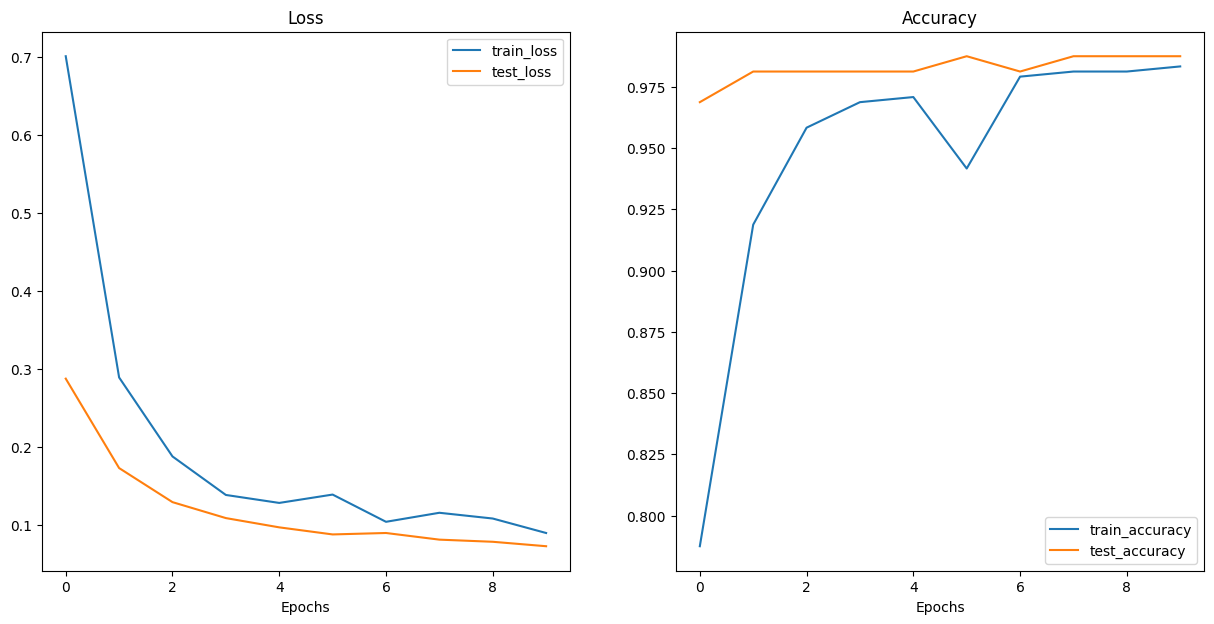

In [ ]:
# Plotting loss and accuracy curves
plot_loss_curves(vit_20_percent_results)

As expected, training a feature extractor on a larger dataset gave us superior results after training for 7 epochs.

Also, this model has better accuracy and lower loss compared to a previous well performing feature extractor *EfficientNetB2*.

**EfficientNetB2**:
- Epoch: 10 | train_loss: 0.3733 | train_acc: 0.8708 | test_loss: 0.2850 | test_acc: 0.9534 | Total training time: 63.85 seconds

**ViT-B/16**:
- Epoch: 10 | train_loss: 0.0901 | train_acc: 0.9833 | test_loss: 0.0731 | test_acc: 0.9875 | Total training time: 154.05 seconds.

BUT, the *EfficientNetB2* feature extractor was trained 2.4x times faster than *ViT-B/16*, and is lighter (193.85 MBs vs. 333.89 MBs).


# Training a pre-trained ViT-B/16 with different weights on the larger dataset

Now, instead of using the default ViT-B/16 weights, we will use the IMAGENET1K_SWAG_E2E_V1 weights.

These weights are learnt via transfer learning by end-to-end fine-tuning the original SWAG weights on ImageNet-1K data.

In [19]:
swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
swag_transforms = swag_weights.transforms()
swag_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [22]:
import os

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = swag_transforms,
                                                                               batch_size = 32,
                                                                               num_workers = os.cpu_count())

class_names, len(train_dataloader)

(['pizza', 'steak', 'sushi'], 15)

In [23]:
vit_swag = torchvision.models.vit_b_16(weights = swag_weights).to(device)

In [24]:
from torchinfo import summary
summary(model = vit_swag,
        input_size = (32,3,384,384),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 384, 384]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 384, 384]    [32, 768, 24, 24]    590,592              True
├─Encoder (encoder)                                          [32, 577, 768]       [32, 577, 768]       443,136              True
│    └─Dropout (dropout)                                     [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Sequential (layers)                                   [32, 577, 768]       [32, 577, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 577, 768]       [32, 577, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 577, 768]       [32, 577, 76

In [25]:
for param in vit_swag.conv_proj.parameters():
  param.requires_grad = False

for param in vit_swag.encoder.parameters():
  param.requires_grad = False

In [26]:
vit_swag.heads = nn.Sequential(
    nn.Linear(in_features = 768, out_features = 3, bias = True)
)

In [27]:
from timeit import default_timer as timer
set_seeds()

optimizer = torch.optim.Adam(params = vit_swag.parameters(),
                             betas = (0.9, 0.999),
                             weight_decay = 0.1,
                             lr = 0.0008)

loss_fn = nn.CrossEntropyLoss()

start_time = timer()

vit_swag_results = engine.train(model = vit_swag,
                                train_dataloader = train_dataloader,
                                test_dataloader = test_dataloader,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

end_time = timer()
print(f'[INFO] Model training was completed in: {end_time - start_time} seconds.')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7008 | train_acc: 0.7417 | test_loss: 0.0844 | test_acc: 0.9938
Epoch: 2 | train_loss: 0.0752 | train_acc: 0.9854 | test_loss: 0.0387 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0434 | train_acc: 0.9917 | test_loss: 0.0210 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0327 | train_acc: 0.9958 | test_loss: 0.0151 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0270 | train_acc: 0.9938 | test_loss: 0.0136 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0249 | train_acc: 0.9979 | test_loss: 0.0118 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0203 | train_acc: 0.9979 | test_loss: 0.0100 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0228 | train_acc: 1.0000 | test_loss: 0.0097 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0165 | train_acc: 1.0000 | test_loss: 0.0103 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0163 | train_acc: 0.9979 | test_loss: 0.0086 | test_acc: 1.0000
[INFO] Model training was completed in: 535.441914621 seconds.


- ViT-B/16 with IMAGENET1K_SWAG_E2E_V1 weights:
train_loss: 0.0163 | train_acc: 0.9979 | test_loss: 0.0086 | test_acc: 1.0000 |
Total training time: 535.44 seconds.

- ViT-B/16 with DEFAULT weights:
Epoch: 10 | train_loss: 0.0901 | train_acc: 0.9833 | test_loss: 0.0731 | test_acc: 0.9875 | Total training time: 154.05 seconds.

We got a perfect accuracy with the IMAGENET1K_SWAG_E2E_V1 weights with almost zero loss, at the cost of a 3.5x increase in train time.